# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [192]:
! git clone https://github.com/DS3001/assignment4

fatal: destination path 'assignment4' already exists and is not an empty directory.


In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

# Q1 Parts 1-2

In [194]:
# Load and clean data
# some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation)

car_dat = pd.read_csv("./assignment4/data/cars_hw.csv")

car_dat = car_dat[['Price', 'Color', 'Seating_Capacity', 'Body_Type', 'Make', 'Make_Year', 'Mileage_Run', 'Fuel_Type', 'Transmission', 'Transmission_Type']]
car_dat.describe()

,Price,Seating_Capacity,Make_Year,Mileage_Run
count,9.760000e+02,976.000000,976.000000,976.000000
mean,7.410195e+05,5.095287,2016.963115,41571.195697
std,3.673234e+05,0.446224,2.818742,24390.995134
min,1.880000e+05,4.000000,2011.000000,1117.000000
25%,4.757500e+05,5.000000,2015.000000,22676.750000
50%,6.665000e+05,5.000000,2017.000000,37570.500000
75%,8.830000e+05,5.000000,2019.000000,57421.250000
max,2.941000e+06,8.000000,2022.000000,99495.000000


In [195]:
car_dat[['Fuel_Type', 'Transmission', 'Transmission_Type']].describe()

,Fuel_Type,Transmission,Transmission_Type
count,976,976,976
unique,3,5,2
top,petrol,5-Speed,Manual
freq,783,749,712


{'whiskers': [<matplotlib.lines.Line2D at 0x7b0cd0feb6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b0cd0feabf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b0cd0fea9e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7b0cd0feb8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b0cd148dde0>],
 'means': []}

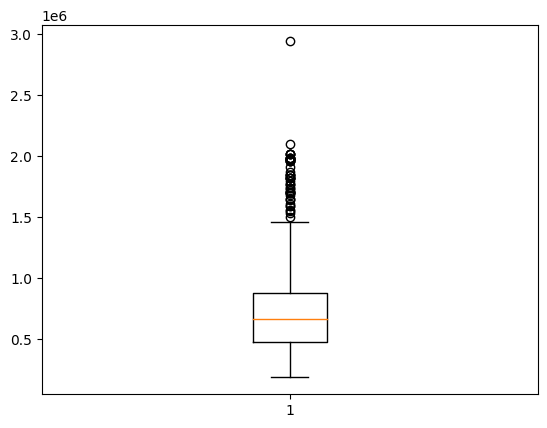

In [196]:
plt.boxplot(car_dat['Price'])

<Axes: >

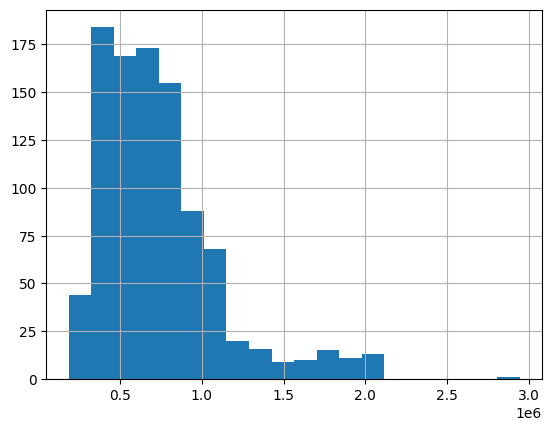

In [197]:
car_dat['Price'].hist(bins=20)

In [198]:
# Convert year to age, makes more sense and will make results of regression accurate
car_dat['Age'] = max(car_dat['Make_Year']) - car_dat['Make_Year']

<Axes: xlabel='Age', ylabel='Price'>

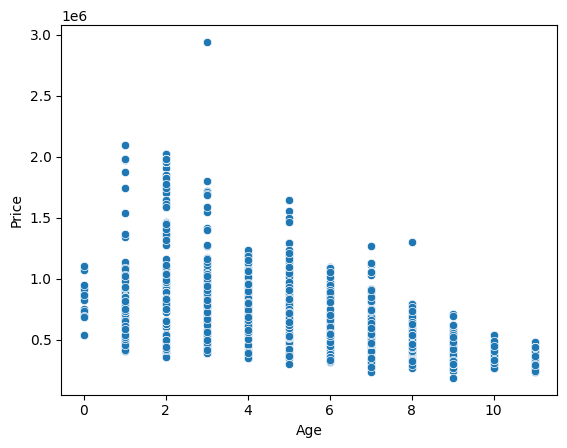

In [199]:
sns.scatterplot(x=car_dat['Age'], y=car_dat['Price'])

In [200]:
# Log transformation on `Price` and `Age` because of its skewness and only positive nums. Not sure when to use arsin vs log.
car_dat['price_log'] = np.log(car_dat['Price'])
car_dat['age_log'] = np.log(car_dat['Age'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='age_log', ylabel='price_log'>

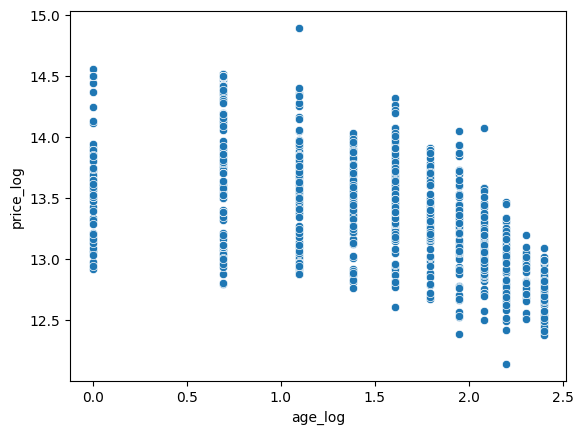

In [201]:
sns.scatterplot(x=car_dat['age_log'], y=car_dat['price_log'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b0cd15523e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b0cd1550610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b0cd15534f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7b0cd15512a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b0cd1553910>],
 'means': []}

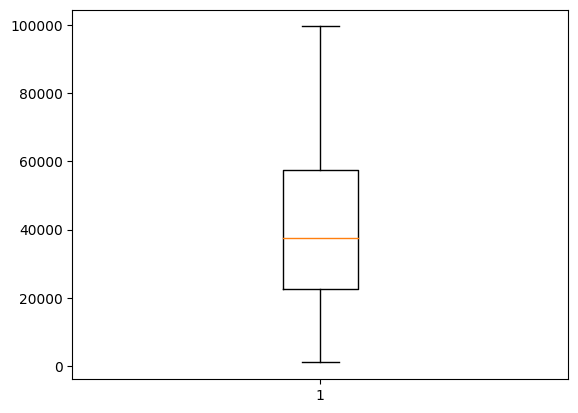

In [202]:
plt.boxplot(car_dat['Mileage_Run'])

<Axes: xlabel='price_log', ylabel='mileage_log'>

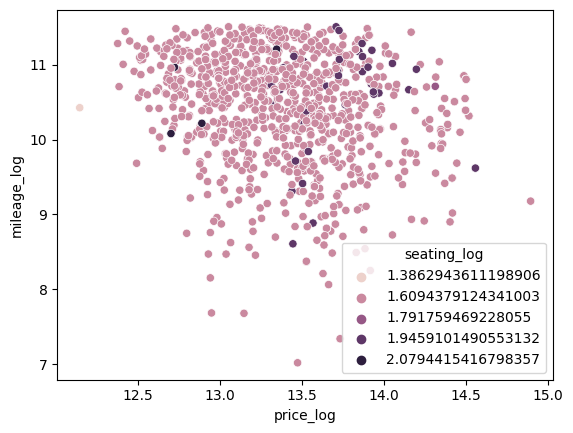

In [203]:
car_dat['mileage_log'] = np.log(car_dat['Mileage_Run'])
car_dat['seating_log'] = np.log(car_dat['Seating_Capacity'])

sns.scatterplot(x=car_dat['price_log'], y=car_dat['mileage_log'], hue=car_dat['seating_log'])

# Seems like all data is relatively close to a normal distribution after performing log transformations

{'whiskers': [<matplotlib.lines.Line2D at 0x7b0cd0dd5db0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b0cd0dd7400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b0cd0dd7fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7b0cd3495a20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b0cd0f75d80>],
 'means': []}

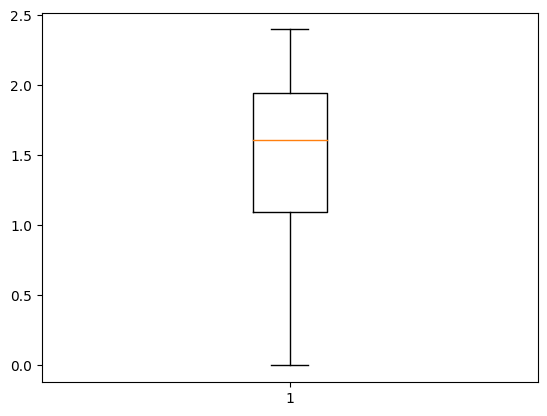

In [204]:
plt.boxplot(car_dat['age_log'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b0cd2e33430>,
 'caps': [<matplotlib.lines.Line2D at 0x7b0cd2e318a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b0cd2e31180>],
 'medians': [<matplotlib.lines.Line2D at 0x7b0cd2e30b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b0cd2e32560>],
 'means': []}

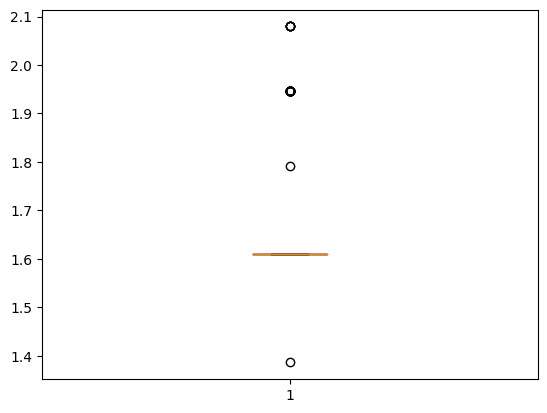

In [205]:
plt.boxplot(car_dat['seating_log'])

<Axes: >

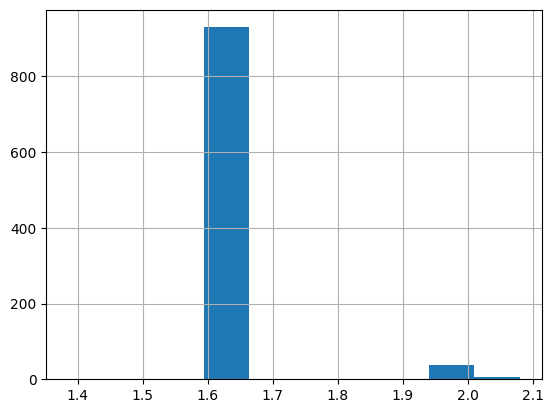

In [206]:
# Numerical with very few unique values and an overwhelmingly majority value, 5.0
car_dat['seating_log'].hist()

<Axes: xlabel='price_log', ylabel='Density'>

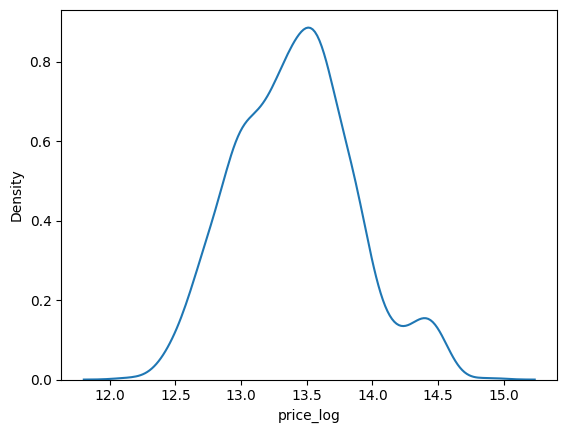

In [207]:
# Kernel density of `Price`
car_dat['price_log'].describe()
sns.kdeplot(x=car_dat['price_log'])

In [208]:
car_dat['price_log'].groupby(car_dat['Make']).describe()

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,12.919895,0.480975,12.495004,12.568392,12.752286,13.171681,13.701221
Datsun,3.0,12.576047,0.036311,12.538967,12.558302,12.577636,12.594587,12.611538
Ford,52.0,13.468280,0.210895,12.577636,13.361380,13.469493,13.575984,13.879424
Honda,73.0,13.536318,0.336972,12.663497,13.272506,13.573439,13.726679,14.245343
Hyundai,305.0,13.368511,0.398781,12.421184,13.091904,13.366094,13.637579,14.370544
Jeep,4.0,14.216591,0.105084,14.070153,14.183270,14.240265,14.273586,14.315680
Kia,8.0,14.292177,0.076877,14.129591,14.272242,14.303105,14.349515,14.369970
MG Motors,35.0,14.439052,0.066263,14.278615,14.395744,14.429615,14.497597,14.518113
Mahindra,18.0,13.898953,0.159906,13.587354,13.851808,13.905680,13.961249,14.197366


<Axes: xlabel='price_log', ylabel='Density'>

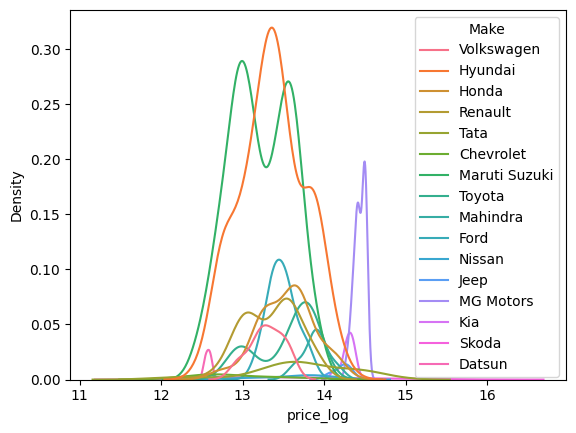

In [209]:
sns.kdeplot(x=car_dat['price_log'], hue=car_dat['Make'])

<font color="green">
After the log transformation performed on `Price`, the data follows fairly closely to a normal distribution, with a singular peak in the middle of the plot. When plotted by `Make`, it is easier to see a high-level breakdown of vehicle prices by vehicle make. We can see that certain makers have higher densities of higher priced vehicles, while some other makers have higher densities of lower priced vehicles. MG Motors produces higher end, or at least higher priced, vehicles. Other makers like Skoda have higher densities of lower-priced vehicles.
</font>

# Q1 Parts 3-4

In [210]:
# Split into 80% training 20% testing datasets
from sklearn.model_selection import train_test_split

# debugging; making sure training data doesnt have nan
car_dat2 = car_dat[['age_log', 'seating_log', 'mileage_log', 'price_log']]
car_dat2.replace([np.inf, -np.inf], np.nan, inplace=True) # pesky inf values messing up model
car_dat2 = car_dat2.dropna()

X = car_dat2[['age_log', 'seating_log', 'mileage_log']] # explanatory vars
y = car_dat2['price_log'] # prediction var

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=64)

print(len(X_train))
print(len(X_test))


769
193


<ipython-input-210-9f6b67a6b3d6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_dat2.replace([np.inf, -np.inf], np.nan, inplace=True) # pesky inf values messing up model


In [211]:
# run MLR using quantitative variables (`age_log', 'seating_log', 'mileage_log')
from sklearn.linear_model import LinearRegression # Import linear regression model

print(X_train.head()) # Peek at data
#print(max(X_train['age_log']))
#print(np.isinf(X_train).any()) # shows there is an infinite value, need to remove it


# fit model
reg = LinearRegression().fit(X_train, y_train)

# predict y vals using test set
y_pred = reg.predict(X_test)

# determine RMSE and R^2 values for model
from sklearn.metrics import mean_squared_error # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", reg.score(X, y)) # R squared measure

      age_log  seating_log  mileage_log
259  1.098612     1.609438    10.301592
157  0.693147     1.609438     9.019785
350  1.945910     1.609438    10.893921
553  0.693147     1.609438    10.416132
710  2.197225     1.609438    10.034560
RMSE value:  0.3820859463865581
R^2 value:  0.34230264378000497


In [212]:
# Make a second model where, for the categorical variables, make a model comprised of one-hot encoded
# regressors/features alone, and regress price on those variables; what is the  𝑅2  and RMSE on the test set? Which model performs better on the test set?

In [213]:
X = car_dat[['Fuel_Type', 'Transmission', 'Transmission_Type']] # explanatory vars
y = car_dat['price_log'] # prediction var

# create df containing "dummies" for each categorical variable
temp_fuel_df = pd.get_dummies(X['Fuel_Type'],dtype='int')
temp_trans_df = pd.get_dummies(X['Transmission'],dtype='int')
temp_transT_df = pd.get_dummies(X['Transmission_Type'],dtype='int')

# combine one-hot encoded variables into one df
X = pd.concat([temp_fuel_df, temp_trans_df,temp_transT_df], axis=1)

# split dat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=64)

# fit model
reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", reg.score(X, y)) # R squared measure

RMSE value:  0.3637953919772567
R^2 value:  0.37003653109181744


<font color="green">
Model 2, created using categorical variables `Fuel_Type`, `Transmission`, and `Transmission_Type`, has a lower RMSE value indicating a more accurate fit of the model when tested with the test data. It also has a higher R<sup>2</sup> value highlighting smaller differences in oberserved and predicted prices. Model 2 performs better on the test set.
</font>

# Q1 Part 5

Use the PolynomialFeatures function from sklearn to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the  𝑅2  and RMSE change? At what point does  𝑅2  go negative on the test set? For your best model with expanded features, what is the  𝑅2  and RMSE? How does it compare to your best model from part 3?

<font color="green">After completing this entire section thoroughly, a refresh caused my work to be lost. For time's sake, I abbreviate here. <br><br>

I already went through and created models for polynomially featured data up to 4 degrees with both the numerical and categorical variables. The highest R<sup>2</sup> value was observed with the 2nd degree numerical model. It also had the second lowest RMSE by a miniscule margin. I will show a scatterplot of the points compared by prediction price and observed price. </font>

In [214]:
# Get X and y back to numerical variables
car_dat2 = car_dat[['age_log', 'seating_log', 'mileage_log', 'price_log']]
car_dat2.replace([np.inf, -np.inf], np.nan, inplace=True) # pesky inf values messing up model
car_dat2 = car_dat2.dropna()

X = car_dat2[['age_log', 'seating_log', 'mileage_log']] # explanatory vars
y = car_dat2['price_log'] # prediction var


<ipython-input-214-6b48f922c742>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_dat2.replace([np.inf, -np.inf], np.nan, inplace=True) # pesky inf values messing up model


In [215]:
from sklearn.preprocessing import PolynomialFeatures

expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

X_train, X_test, y_train, y_test = train_test_split(zdf, y, test_size=.2, random_state=36)

In [220]:
# fit model
reg = LinearRegression().fit(X_train, y_train)

# predict y vals using test set
y_pred = reg.predict(X_test)

# determine RMSE and R^2 values for model
from sklearn.metrics import mean_squared_error # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", reg.score(zdf, y)) # R squared measure

RMSE value:  0.351238977985248
R^2 value:  0.45048714091932573


<font color="green">
In general, as you increase the polynomial features, the R<sup>2</sup> value continues to increase suggesting better fit, for the model is quickly becoming overfit. However, it gets to a point where it becomes negative because of drastic overfitting. There was a decrease in RMSE between the original data and the 2nd order featured data, suggesting better data fit. However, the decreasing RMSE becomes marginally beneficial as you add features.
</font>

# Q1 Part 6

For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

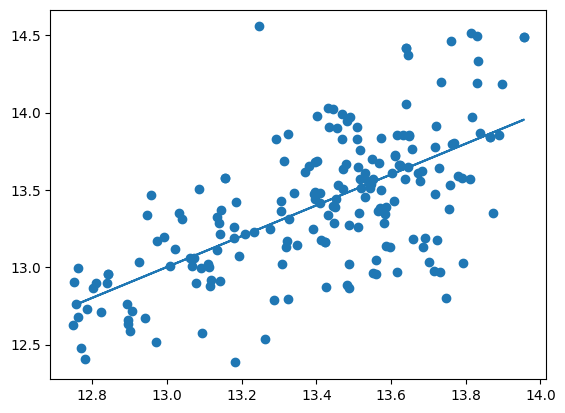

In [221]:
x = pd.Series(y_pred)
y = y_test

plt.scatter(x, y)

#find line of best fit
a, b = np.polyfit(x, y, 1)

#add line of best fit to plot
plt.plot(x, a*x+b)


# calculate residuals
temp = x - y
diff_series = temp.abs()


<Axes: ylabel='Density'>

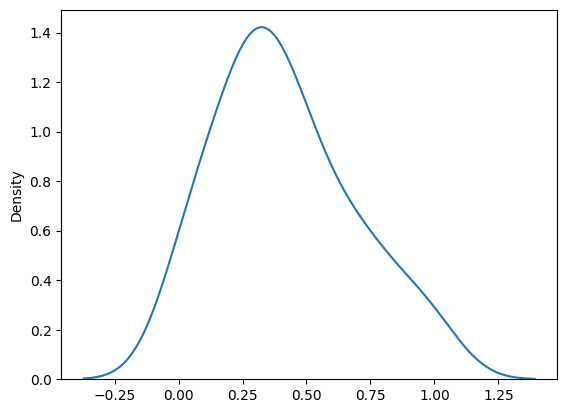

In [222]:
sns.kdeplot(x=diff_series)

<font color="green">
These residuals are fairly normally distributed with a right skew. This model seems to be very strong. It has a high coefficient of determination, low root mean of squared errors, and a very normaly distributed sample of residuals between observed and predicted prices.
</font>

# Q1 Part 7

Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)), and compute the  𝑅2  and RMSE on the test set of a variety of depths. What depth tree gives the best results?

## Tree with numericals

In [223]:
from sklearn import tree # Import the tree classifier
from sklearn import metrics

# Process data:
y_tree = car_dat2['price_log']
X_tree = car_dat2[['seating_log', 'age_log', 'mileage_log']]

# split data
X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=.2, random_state=57)

RMSE value:  0.36280384013646033
R^2 value:  0.37236456502146487


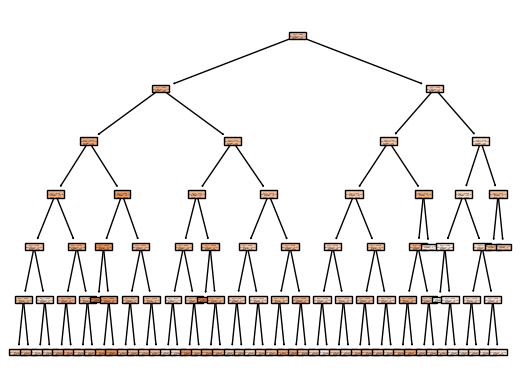

In [224]:
## MAX_DEPTH: 6 ##

y_test_best = y_test

# Fit decision tree
cart = tree.DecisionTreeRegressor(max_depth = 6) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

# Visualize results:
tree.plot_tree(cart,filled=True)

y_pred = cart.predict(X_test)

# Calculate R^2 and RMSE
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", metrics.r2_score(y_test, y_pred)) # R squared measure

RMSE value:  0.36548664930356034
R^2 value:  0.36304795054288674


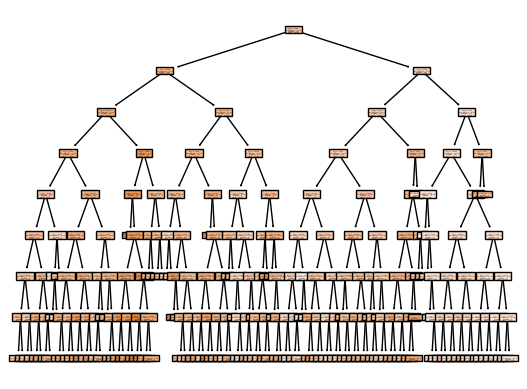

In [225]:
## MAX_DEPTH: 8 ##

# Fit decision tree:
cart = tree.DecisionTreeRegressor(max_depth = 8) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

# Visualize results:
tree.plot_tree(cart,filled=True)

y_pred = cart.predict(X_test)

# Calculate R^2 and RMSE
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", metrics.r2_score(y_test, y_pred)) # R squared measure

RMSE value:  0.36548664930356034
R^2 value:  0.3738267975983457


[Text(0.5420961394302849, 0.9545454545454546, 'x[1] <= 1.869\nsquared_error = 0.203\nsamples = 769\nvalue = 13.413'),
 Text(0.2945792728635682, 0.8636363636363636, 'x[1] <= 0.896\nsquared_error = 0.161\nsamples = 536\nvalue = 13.569'),
 Text(0.1794883808095952, 0.7727272727272727, 'x[2] <= 10.316\nsquared_error = 0.219\nsamples = 167\nvalue = 13.758'),
 Text(0.10016866566716642, 0.6818181818181818, 'x[2] <= 8.795\nsquared_error = 0.168\nsamples = 118\nvalue = 13.622'),
 Text(0.041979010494752625, 0.5909090909090909, 'x[2] <= 8.728\nsquared_error = 0.093\nsamples = 14\nvalue = 13.325'),
 Text(0.026986506746626688, 0.5, 'x[2] <= 8.482\nsquared_error = 0.069\nsamples = 11\nvalue = 13.419'),
 Text(0.014992503748125937, 0.4090909090909091, 'x[2] <= 8.416\nsquared_error = 0.036\nsamples = 5\nvalue = 13.28'),
 Text(0.008995502248875561, 0.3181818181818182, 'x[1] <= 0.347\nsquared_error = 0.028\nsamples = 3\nvalue = 13.382'),
 Text(0.005997001499250375, 0.22727272727272727, 'x[2] <= 7.349\nsqu

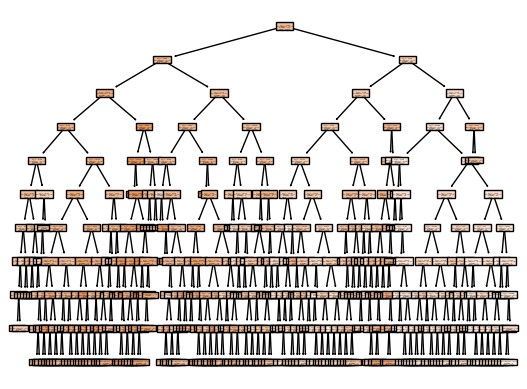

In [226]:
## MAX_DEPTH: 10 ##

# Fit decision tree:
cart = tree.DecisionTreeRegressor(max_depth = 10) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

y_pred_10 = cart.predict(X_test)

# Calculate R^2 and RMSE
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", metrics.r2_score(y_test, y_pred_10)) # R squared measure

# Visualize results:
tree.plot_tree(cart,filled=True)

RMSE value:  0.3880963619537116
R^2 value:  0.2818042219778055


[Text(0.5311102676187934, 0.9615384615384616, 'x[1] <= 1.869\nsquared_error = 0.203\nsamples = 769\nvalue = 13.413'),
 Text(0.2714103376935398, 0.8846153846153846, 'x[1] <= 0.896\nsquared_error = 0.161\nsamples = 536\nvalue = 13.569'),
 Text(0.15730946342765617, 0.8076923076923077, 'x[2] <= 10.316\nsquared_error = 0.219\nsamples = 167\nvalue = 13.758'),
 Text(0.08650894287239723, 0.7307692307692307, 'x[2] <= 8.795\nsquared_error = 0.168\nsamples = 118\nvalue = 13.622'),
 Text(0.02989855846235985, 0.6538461538461539, 'x[2] <= 8.728\nsquared_error = 0.093\nsamples = 14\nvalue = 13.325'),
 Text(0.019220501868659905, 0.5769230769230769, 'x[2] <= 8.482\nsquared_error = 0.069\nsamples = 11\nvalue = 13.419'),
 Text(0.010678056593699947, 0.5, 'x[2] <= 8.416\nsquared_error = 0.036\nsamples = 5\nvalue = 13.28'),
 Text(0.006406833956219968, 0.4230769230769231, 'x[1] <= 0.347\nsquared_error = 0.028\nsamples = 3\nvalue = 13.382'),
 Text(0.004271222637479978, 0.34615384615384615, 'x[2] <= 7.349\nsqu

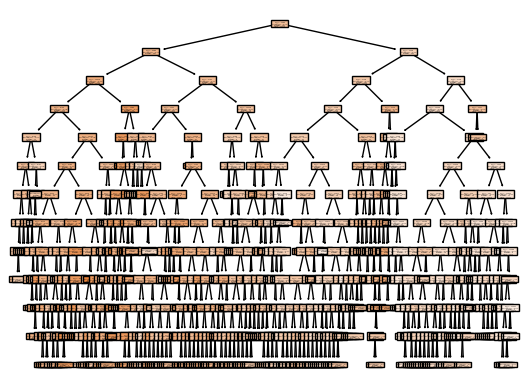

In [227]:
## MAX_DEPTH: 12 ##

# Fit decision tree:
cart = tree.DecisionTreeRegressor(max_depth = 12) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

y_pred = cart.predict(X_test)

# Calculate R^2 and RMSE
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", metrics.r2_score(y_test, y_pred)) # R squared measure

# Visualize results:
tree.plot_tree(cart,filled=True)

<font color="green">
The RMSE and R<sup>2</sup> are optimized with my max_depth=10 tree.
<br> <br>
RMSE value:  0.3634186737592689<br>
R<sup>2</sup> value:  0.6801270987428811
<br> <br>

The max_depth=12 tree has a similiar and comparable set of values, with RMSE RMSE value:  0.387 and
R<sup>2</sup> value:  0.718. However, I think this relatively equal increase in both values when going from depth=10 to depth =12 suggests that the the additional 2 layers of the tree are not marginally beneficial for predicting the data.
</font>

## Tree with categoricals

In [228]:
X1 = car_dat[['Fuel_Type', 'Transmission', 'Transmission_Type']] # explanatory vars
y = car_dat['price_log'] # prediction var

# create df containing "dummies" for each categorical variable
temp_fuel_df = pd.get_dummies(X1['Fuel_Type'],dtype='int')
temp_trans_df = pd.get_dummies(X1['Transmission'],dtype='int')
temp_transT_df = pd.get_dummies(X1['Transmission_Type'],dtype='int')

# combine one-hot encoded variables into one df
X = pd.concat([temp_fuel_df, temp_trans_df,temp_transT_df], axis=1)

# split dat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=64)


RMSE value:  0.3584714262668821
R^2 value:  0.41389639598768


[Text(0.5869565217391305, 0.9, 'x[5] <= 0.5\nsquared_error = 0.198\nsamples = 780\nvalue = 13.412'),
 Text(0.34782608695652173, 0.7, 'x[0] <= 0.5\nsquared_error = 0.153\nsamples = 643\nvalue = 13.304'),
 Text(0.17391304347826086, 0.5, 'x[6] <= 0.5\nsquared_error = 0.142\nsamples = 566\nvalue = 13.264'),
 Text(0.08695652173913043, 0.3, 'x[9] <= 0.5\nsquared_error = 0.129\nsamples = 555\nvalue = 13.249'),
 Text(0.043478260869565216, 0.1, 'squared_error = 0.095\nsamples = 132\nvalue = 13.368'),
 Text(0.13043478260869565, 0.1, 'squared_error = 0.134\nsamples = 423\nvalue = 13.211'),
 Text(0.2608695652173913, 0.3, 'x[9] <= 0.5\nsquared_error = 0.162\nsamples = 11\nvalue = 14.046'),
 Text(0.21739130434782608, 0.1, 'squared_error = 0.182\nsamples = 7\nvalue = 14.114'),
 Text(0.30434782608695654, 0.1, 'squared_error = 0.104\nsamples = 4\nvalue = 13.926'),
 Text(0.5217391304347826, 0.5, 'x[9] <= 0.5\nsquared_error = 0.137\nsamples = 77\nvalue = 13.597'),
 Text(0.43478260869565216, 0.3, 'x[6] <=

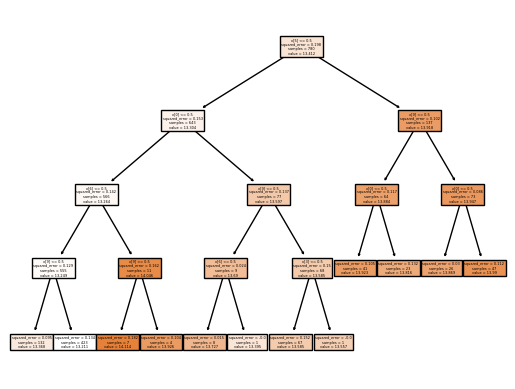

In [229]:
## MAX_DEPTH: 4 ##

# Fit decision tree:
cart = tree.DecisionTreeRegressor(max_depth = 4) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

y_pred = cart.predict(X_test)

# Calculate R^2 and RMSE
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", metrics.r2_score(y_test, y_pred)) # R squared measure

# Visualize results:
tree.plot_tree(cart,filled=True)

RMSE value:  0.35833373356422676
R^2 value:  0.4143465668190148


[Text(0.6435185185185185, 0.9285714285714286, 'x[5] <= 0.5\nsquared_error = 0.198\nsamples = 780\nvalue = 13.412'),
 Text(0.4351851851851852, 0.7857142857142857, 'x[0] <= 0.5\nsquared_error = 0.153\nsamples = 643\nvalue = 13.304'),
 Text(0.2777777777777778, 0.6428571428571429, 'x[6] <= 0.5\nsquared_error = 0.142\nsamples = 566\nvalue = 13.264'),
 Text(0.18518518518518517, 0.5, 'x[8] <= 0.5\nsquared_error = 0.129\nsamples = 555\nvalue = 13.249'),
 Text(0.1111111111111111, 0.35714285714285715, 'x[3] <= 0.5\nsquared_error = 0.134\nsamples = 423\nvalue = 13.211'),
 Text(0.07407407407407407, 0.21428571428571427, 'x[1] <= 0.5\nsquared_error = 0.129\nsamples = 410\nvalue = 13.215'),
 Text(0.037037037037037035, 0.07142857142857142, 'squared_error = 0.003\nsamples = 2\nvalue = 13.382'),
 Text(0.1111111111111111, 0.07142857142857142, 'squared_error = 0.13\nsamples = 408\nvalue = 13.214'),
 Text(0.14814814814814814, 0.21428571428571427, 'squared_error = 0.253\nsamples = 13\nvalue = 13.093'),
 Tex

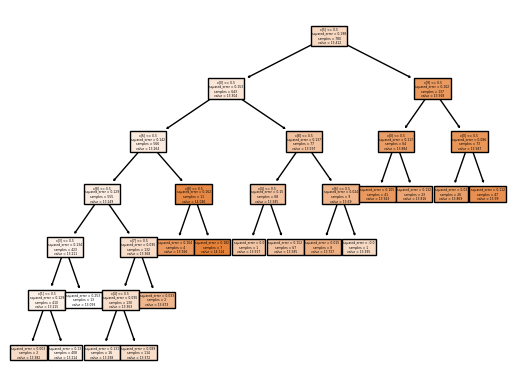

In [230]:
## MAX_DEPTH: 6 ##

# Fit decision tree:
cart = tree.DecisionTreeRegressor(max_depth = 6) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

y_pred = cart.predict(X_test)

# Calculate R^2 and RMSE
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", metrics.r2_score(y_test, y_pred)) # R squared measure

# Visualize results:
tree.plot_tree(cart,filled=True)

RMSE value:  0.35741870864273856
R^2 value:  0.4173337445669111


[Text(0.6517857142857143, 0.9285714285714286, 'x[5] <= 0.5\nsquared_error = 0.198\nsamples = 780\nvalue = 13.412'),
 Text(0.44642857142857145, 0.7857142857142857, 'x[0] <= 0.5\nsquared_error = 0.153\nsamples = 643\nvalue = 13.304'),
 Text(0.2857142857142857, 0.6428571428571429, 'x[6] <= 0.5\nsquared_error = 0.142\nsamples = 566\nvalue = 13.264'),
 Text(0.17857142857142858, 0.5, 'x[8] <= 0.5\nsquared_error = 0.129\nsamples = 555\nvalue = 13.249'),
 Text(0.07142857142857142, 0.35714285714285715, 'x[4] <= 0.5\nsquared_error = 0.134\nsamples = 423\nvalue = 13.211'),
 Text(0.03571428571428571, 0.21428571428571427, 'squared_error = 0.253\nsamples = 13\nvalue = 13.093'),
 Text(0.10714285714285714, 0.21428571428571427, 'x[2] <= 0.5\nsquared_error = 0.129\nsamples = 410\nvalue = 13.215'),
 Text(0.07142857142857142, 0.07142857142857142, 'squared_error = 0.13\nsamples = 408\nvalue = 13.214'),
 Text(0.14285714285714285, 0.07142857142857142, 'squared_error = 0.003\nsamples = 2\nvalue = 13.382'),
 T

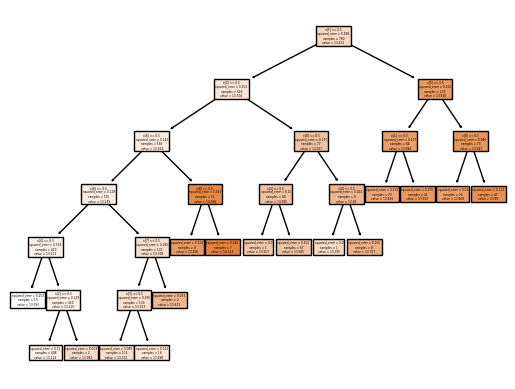

In [231]:
## MAX_DEPTH: 10 ##

# Fit decision tree:
cart = tree.DecisionTreeRegressor(max_depth = 10) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

y_pred = cart.predict(X_test)

# Calculate R^2 and RMSE
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", metrics.r2_score(y_test, y_pred)) # R squared measure

# Visualize results:
tree.plot_tree(cart,filled=True)

<font color="green">

</font>

<font color="green">
The best model, determined by RMSE and R<sup>2</sup> values, is our decision tree using the categorical variables with a max-depth of 10.
</font>

# Q1 Part 8
For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?

[13.21431444 13.21431444 13.8692204  13.8692204  13.21431444 13.72701783
 13.37235878 13.21431444 13.37235878 13.21431444 13.21431444 14.11404355
 13.37235878 13.21431444 13.21431444 13.21431444 13.37235878 13.8692204
 13.8692204  13.21431444 13.21431444 13.9898162  13.37235878 13.58512321
 13.21431444 13.58512321 13.21431444 13.21431444 13.9898162  13.9898162
 13.92260664 13.21431444 13.72701783 13.21431444 13.8692204  13.58512321
 13.21431444 13.21431444 13.37235878 13.37235878 13.21431444 13.37235878
 13.21431444 13.21431444 13.58512321 13.21431444 13.72701783 13.9898162
 13.8161818  13.37235878 13.58512321 13.9898162  13.58512321 13.21431444
 13.21431444 13.58512321 13.9898162  13.37235878 13.37235878 13.21431444
 13.21431444 13.21431444 13.21431444 13.9898162  13.21431444 13.21431444
 13.21431444 13.9898162  13.72701783 13.21431444 13.58512321 13.37235878
 13.37235878 13.92260664 13.9898162  13.9898162  13.58512321 13.9261283
 13.21431444 13.37235878 13.21431444 13.8161818  13.214

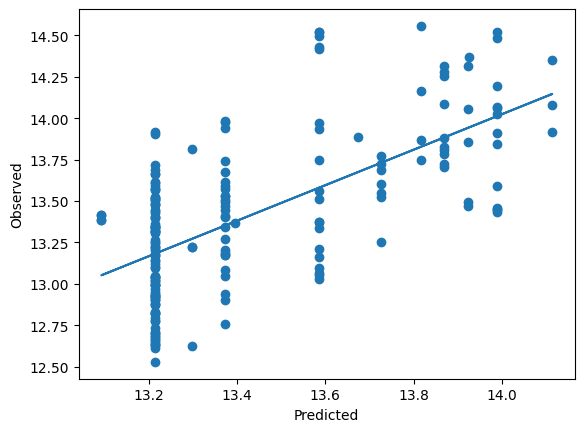

In [232]:
# Results of depth=10 categorical tree
print(y_pred)
x = y_pred
y = y_test

# Scatterplot predicted values and true values
plt.scatter(x, y)

#find line of best fit
a, b = np.polyfit(x, y, 1)

#add line of best fit to plot
plt.plot(x, a*x+b)
plt.xlabel("Predicted")
plt.ylabel("Observed")

# calculate residuals
temp = x - y
diff_series = temp.abs()

<Axes: xlabel='price_log', ylabel='Density'>

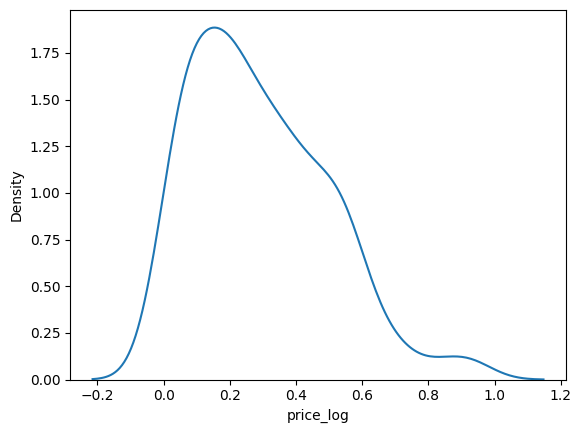

In [233]:
# create kernel density plot of residuals
sns.kdeplot(x=diff_series)

<font color = "green">
The scatterplot of predicted values against oberved values has a fitted line that travels just below the xy axis, the diagonal, suggesting a good fit our of model. When looking at the kernel density plot of the residuals, we see that it is roughly a normal distribution, with a large peak around 0. However, because of the right skew of the data, (I theorize) the residuals also have a slight right skew where there exists a large tail on the right side of the plot.
</font>

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

# Q3 Parts 1-2

In [239]:
contra_dat = pd.read_csv("./assignment4/data/contraception_hw.csv")

print(contra_dat['method'].value_counts())

print(pd.crosstab(contra_dat['method'], contra_dat['numberChildren']))

1    629
3    511
2    333
Name: method, dtype: int64
numberChildren  0    1    2    3   4   5   6   7   8   9   10  11  12  13  16
method                                                                       
1               95  143  114   70  57  44  35  18  29   5   9   6   4   0   0
2                0   46   56   70  62  36  27  19   9   3   2   2   0   1   0
3                2   87  106  119  78  55  30  12   9   8   0   3   0   1   1


<font color="green">
In general, couples that do not use contraception (method 1), tend to have fewer children. However, method 1 couples have higher frequencies of 8+ children. The couples that do use contraception (methods 2 and 3), tend to have more children, with the exception of high numbers of children.
<br> <br>
Couples that do not use contraception either have 0 to few children or many children, while couples that use contracpetion tend to more often have 2-7 children.
</font>

# Q3 Part 3

We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here

In [ ]:
# separate features and outcome variables
X = contra_dat[['age', 'numberChildren', 'edu', 'edu_spouse', 'religion', 'working', 'spouse_occupation', 'standardOfLivingIndex', 'mediaExposure']]
y = contra_dat['method']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=34)

RMSE value:  0.8156576460242284
R^2 value:  0.11849108031462718


[Text(0.36363636363636365, 0.9, 'x[1] <= 0.5\nsquared_error = 0.771\nsamples = 1178\nvalue = 1.917'),
 Text(0.09090909090909091, 0.7, 'x[0] <= 17.5\nsquared_error = 0.101\nsamples = 77\nvalue = 1.052'),
 Text(0.045454545454545456, 0.5, 'squared_error = 0.0\nsamples = 1\nvalue = 3.0'),
 Text(0.13636363636363635, 0.5, 'x[6] <= 3.5\nsquared_error = 0.052\nsamples = 76\nvalue = 1.026'),
 Text(0.09090909090909091, 0.3, 'squared_error = 0.0\nsamples = 73\nvalue = 1.0'),
 Text(0.18181818181818182, 0.3, 'x[4] <= 0.5\nsquared_error = 0.889\nsamples = 3\nvalue = 1.667'),
 Text(0.13636363636363635, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = 3.0'),
 Text(0.22727272727272727, 0.1, 'squared_error = 0.0\nsamples = 2\nvalue = 1.0'),
 Text(0.6363636363636364, 0.7, 'x[0] <= 37.5\nsquared_error = 0.762\nsamples = 1101\nvalue = 1.977'),
 Text(0.45454545454545453, 0.5, 'x[1] <= 2.5\nsquared_error = 0.76\nsamples = 770\nvalue = 2.127'),
 Text(0.36363636363636365, 0.3, 'x[0] <= 35.5\nsquared_error = 0.8

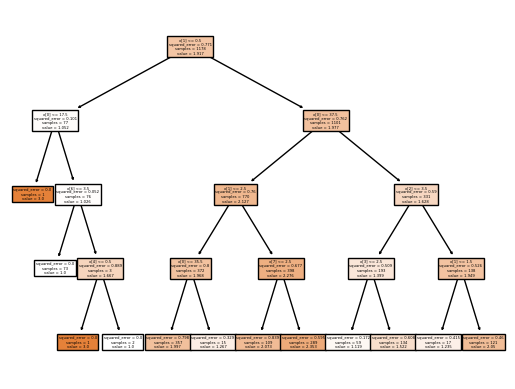

In [243]:
# Fit decision tree:
cart = tree.DecisionTreeRegressor(max_depth=4) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

y_pred = cart.predict(X_test)

# Calculate R^2 and RMSE
print("RMSE value: ", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("R^2 value: ", metrics.r2_score(y_test, y_pred)) # R squared measure

# Visualize results:
tree.plot_tree(cart,filled=True)


<font color="green">
Using a regression tree makes no sense here, as we are trying to predict which independent, standalone contraception method observations (couples) use. Because contraception is a factored variable with levels 1, 2, 3, this variable is not continuous, so a predicted value of 1.5 or 2.3 or any other predicted value does not make sense in the context of our problem. Regression cannot place our observations into distinct, leveled buckets. Classificiation must be used to predict a categorical variable like contraception method.
</font>

# Q4 Part 4

Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

R^2 value:  0.5491525423728814


[Text(0.3108108108108108, 0.9166666666666666, 'x[1] <= 0.5\ngini = 0.645\nsamples = 1178\nvalue = [507, 262, 409]'),
 Text(0.05405405405405406, 0.75, 'x[0] <= 17.5\ngini = 0.051\nsamples = 77\nvalue = [75, 0, 2]'),
 Text(0.02702702702702703, 0.5833333333333334, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.08108108108108109, 0.5833333333333334, 'x[6] <= 3.5\ngini = 0.026\nsamples = 76\nvalue = [75, 0, 1]'),
 Text(0.05405405405405406, 0.4166666666666667, 'gini = 0.0\nsamples = 73\nvalue = [73, 0, 0]'),
 Text(0.10810810810810811, 0.4166666666666667, 'x[3] <= 3.0\ngini = 0.444\nsamples = 3\nvalue = [2, 0, 1]'),
 Text(0.08108108108108109, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.13513513513513514, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]'),
 Text(0.5675675675675675, 0.75, 'x[0] <= 37.5\ngini = 0.653\nsamples = 1101\nvalue = [432, 262, 407]'),
 Text(0.35135135135135137, 0.5833333333333334, 'x[1] <= 2.5\ngini = 0.64\nsamples = 770\nvalue = [250, 172, 348

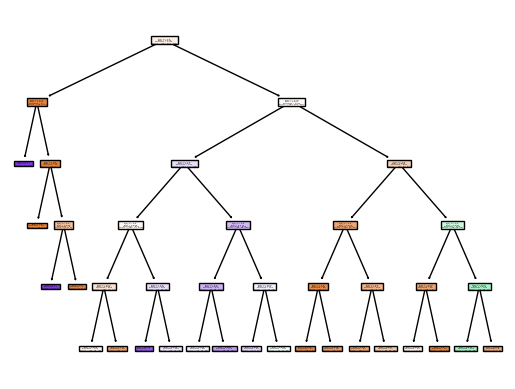

In [268]:
# Fit classification tree:
cart = tree.DecisionTreeClassifier(max_depth = 5) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

y_pred = cart.predict(X_test)

print("R^2 value: ", metrics.accuracy_score(y_test, y_pred)) # R squared measure

# Visualize results:
tree.plot_tree(cart,filled=True)

<font color="green">
In this classifier tree, the terminal nodes are distinct colors, each color corresponding to a different predicted category. Because we are using classification, these terminal nodes represent either 1, 2, or 3 for the predicted method variable.
</font>

In [275]:
# get importance values for each variable used in classifier
feature_importances = cart.feature_importances_
df = pd.DataFrame({'Variables': X_test.columns, 'Importances': feature_importances})
df.head(9)

,Variables,Importances
0,age,0.295973
1,numberChildren,0.379619
2,edu,0.246537
3,edu_spouse,0.047091
4,religion,0.000000
5,working,0.000000
6,spouse_occupation,0.003937
7,standardOfLivingIndex,0.026844
8,mediaExposure,0.000000


<font color="green">
The variables `numberChildren`, `age`, and `edu` are the main variables used in this classification decision tree.
</font>

In [276]:
# what types of people use which methods of bc


y_pred_ct = pd.Series(y_pred)

result_df = pd.concat([X, y_pred_ct], axis=1)

# combine X_test with predicted values to see which types of people use which method of bc
result_df['predicted'] = result_df[0]

result_df.head()

,age,numberChildren,edu,edu_spouse,religion,working,spouse_occupation,standardOfLivingIndex,mediaExposure,0,predicted
0,24,3,2,3,1,1,2,3,0,3.0,3.0
1,45,10,1,3,1,1,3,4,0,3.0,3.0
2,43,7,2,3,1,1,3,4,0,1.0,1.0
3,42,9,3,2,1,1,3,3,0,3.0,3.0
4,36,8,3,3,1,1,3,2,0,2.0,2.0


In [277]:
pd.crosstab(result_df['numberChildren'], result_df['predicted'])

predicted,1.0,2.0,3.0
numberChildren,,,
0,23,5,16
1,29,16,22
2,21,13,23
3,10,7,14
4,8,6,13
5,11,1,10
6,4,2,7
7,3,2,4
8,6,1,7


In [278]:
pd.crosstab(result_df['age'], result_df['predicted'])

predicted,1.0,2.0,3.0
age,,,
17,0,0,1
18,0,0,1
19,3,0,1
20,3,3,2
21,6,1,3
22,5,2,9
23,3,1,3
24,6,3,3
25,7,3,1


In [279]:
pd.crosstab(result_df['edu'], result_df['predicted'])

predicted,1.0,2.0,3.0
edu,,,
1,15,8,23
2,36,22,31
3,31,14,29
4,38,10,38


<font color="green">
In general, it seems to be that people with children but fewer than 5-6 children that are in the upper categories of standard of living are most likely to use birth control, either method 1 or 2.
</font>

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?